harvesting states...
fitting...
training error:
0.021726779528515563


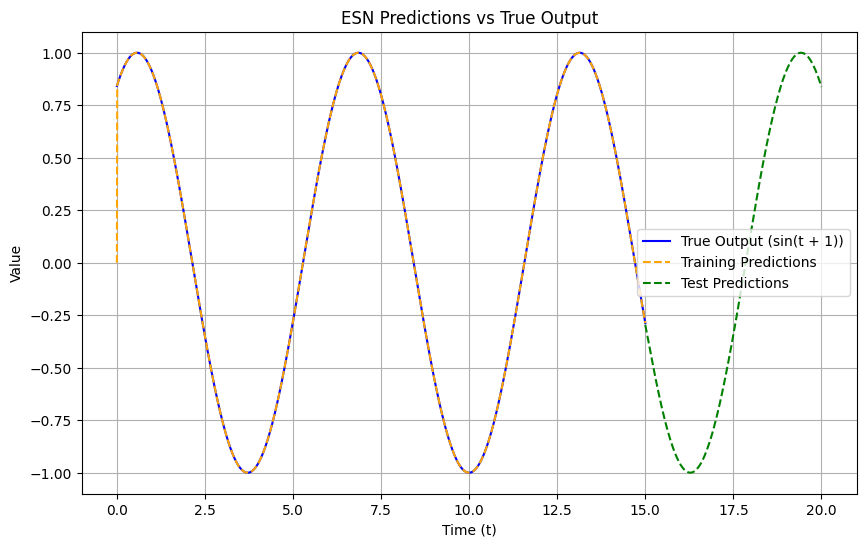

Training RMSE: 0.0217


In [1]:
from pyESN import ESN
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data (sine wave)
t = np.linspace(0, 15, 1500)  # Increased range for better visualization
inputs = np.sin(t).reshape(-1, 1)
outputs = np.sin(t + 1).reshape(-1, 1)  # Target: shifted sine wave

# Create and train the ESN
esn = ESN(n_inputs=1, n_outputs=1, n_reservoir=200, spectral_radius=0.95, random_state=42, silent=False)
pred_train = esn.fit(inputs, outputs, inspect=False)  # Set inspect=False to avoid heatmap for now

# Predict on test data
test_t = np.linspace(15, 20, 500)
test_inputs = np.sin(test_t).reshape(-1, 1)
predictions = esn.predict(test_inputs)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, outputs, label='True Output (sin(t + 1))', color='blue')
plt.plot(t[:len(pred_train)], pred_train, label='Training Predictions', color='orange', linestyle='--')
plt.plot(test_t, predictions, label='Test Predictions', color='green', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('ESN Predictions vs True Output')
plt.legend()
plt.grid(True)
plt.show()

print(f"Training RMSE: {np.sqrt(np.mean((pred_train - outputs[:len(pred_train)])**2)):.4f}")

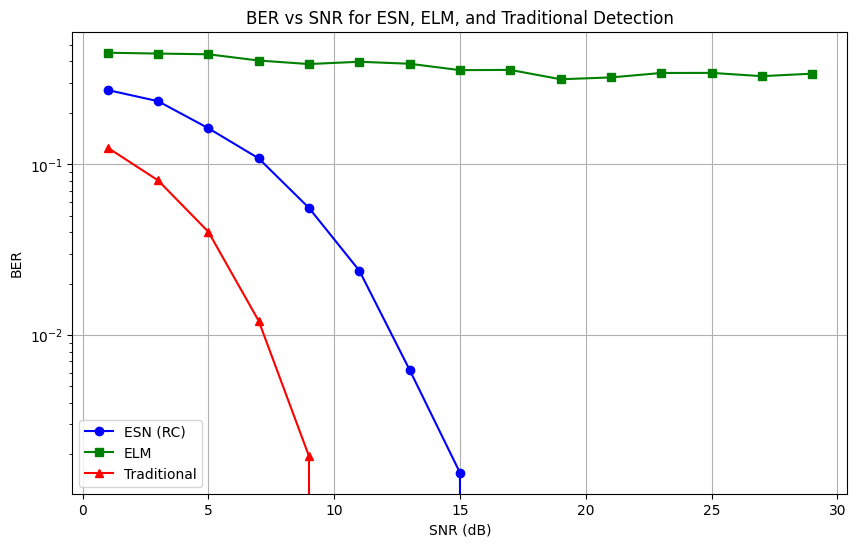

In [15]:
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# Parameters
N_c = 64  # Number of sub-carriers (reduced for speed)
N_cp = 8   # Cyclic prefix length
Q_train = 200  # Training symbols
Q_test = 20   # Testing symbols
N_n_esn = 200  # Neurons for ESN (RC)
N_hidden_elm = 200  # Hidden nodes for ELM
spectral_radius = 0.9  # For ESN
snr_range = range(1, 30, 2)  # SNR from 1 to 29 dB in steps of 2

# 4-QAM constellation
constellation = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)

# Generate OFDM SISO data
def generate_ofdm_data(Q, EbN0_dB):
    Z = np.zeros((Q, N_c), dtype=complex)  # Frequency-domain
    X_tilde = np.zeros((Q, N_c + N_cp), dtype=complex)  # Tx time-domain
    X = np.zeros((Q, N_c + N_cp), dtype=complex)  # Rx time-domain
    for q in range(Q):
        indices = np.random.randint(0, len(constellation), N_c)
        Z[q] = constellation[indices]
        Z_tilde = ifft(Z[q]) * np.sqrt(N_c)
        cp = Z_tilde[-N_cp:]
        X_tilde[q] = np.concatenate([cp, Z_tilde])
        # AWGN channel
        noise_power = 10**(-EbN0_dB / 10)
        noise = np.sqrt(noise_power / 2) * (np.random.randn(N_c + N_cp) + 1j * np.random.randn(N_c + N_cp))
        X[q] = X_tilde[q] + noise
    return X, X_tilde, Z

# ESN (Reservoir Computing) Class
class EchoStateNetwork:
    def __init__(self, N_n, spectral_radius=0.95):
        self.N_n = N_n
        self.W_s = np.random.randn(N_n, N_n) * 0.1
        self.W_s *= spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W_s)))
        self.W_in = np.random.uniform(-0.5, 0.5, (N_n, 2))  # Real/imag input
        self.W_tout = None
        self.f = np.tanh

    def collect_states(self, X):
        T = X.shape[1]
        S = np.zeros((X.shape[0], T, self.N_n))
        for q in range(X.shape[0]):
            s_t = np.zeros(self.N_n)
            for t in range(T):
                x_t = np.array([X[q, t].real, X[q, t].imag])
                s_t = self.f(s_t @ self.W_s + x_t @ self.W_in.T)
                S[q, t, :] = s_t
        return S

    def train(self, S, Z):
        S_data = S[:, N_cp:, :]  # Discard CP
        S_flat = S_data.reshape(S.shape[0], -1)  # Q x (N_c * N_n)
        Y_real = np.real(Z).reshape(Z.shape[0], N_c)
        Y_imag = np.imag(Z).reshape(Z.shape[0], N_c)
        Y_target = np.hstack([Y_real, Y_imag])  # Q x (2 * N_c)
        alpha = 1e-3
        F = S_flat.shape[1]
        A = S_flat.T @ S_flat + alpha * np.eye(F)
        B = S_flat.T @ Y_target
        self.W_tout = np.linalg.solve(A, B)

    def predict(self, S):
        S_data = S[:, N_cp:, :]
        S_flat = S_data.reshape(S.shape[0], -1)
        Y = S_flat @ self.W_tout
        N = Y.shape[1] // 2
        Y_complex = Y[:, :N] + 1j * Y[:, N:]
        return Y_complex

# ELM Class
class ExtremeLearningMachine:
    def __init__(self, N_hidden):
        self.N_hidden = N_hidden
        self.W_in = None  # To be initialized during training
        self.beta = None  # Output weights

    def train(self, X, Z):
        Q = X.shape[0]
        T = X.shape[1]
        # Flatten time-domain input (real/imag parts)
        X_flat = np.hstack([np.real(X).reshape(Q, -1), np.imag(X).reshape(Q, -1)])  # Q x (2 * T)
        input_size = X_flat.shape[1]
        self.W_in = np.random.uniform(-0.5, 0.5, (self.N_hidden, input_size))
        # Hidden layer output (sigmoid activation)
        H = 1 / (1 + np.exp(- (X_flat @ self.W_in.T)))  # Q x N_hidden
        # Targets
        Y_real = np.real(Z).reshape(Q, N_c)
        Y_imag = np.imag(Z).reshape(Q, N_c)
        Y_target = np.hstack([Y_real, Y_imag])  # Q x (2 * N_c)
        # Ridge regression for output weights
        alpha = 1e-3
        A = H.T @ H + alpha * np.eye(self.N_hidden)
        B = H.T @ Y_target
        self.beta = np.linalg.solve(A, B)

    def predict(self, X):
        Q = X.shape[0]
        X_flat = np.hstack([np.real(X).reshape(Q, -1), np.imag(X).reshape(Q, -1)])
        H = 1 / (1 + np.exp(- (X_flat @ self.W_in.T)))
        Y = H @ self.beta
        N = Y.shape[1] // 2
        Y_complex = Y[:, :N] + 1j * Y[:, N:]
        return Y_complex

# Compute BER
def compute_ber(Z_pred, Z_true):
    symbols_pred = [np.argmin(np.abs(z - constellation)) for z in Z_pred.flatten()]
    symbols_true = [np.argmin(np.abs(z - constellation)) for z in Z_true.flatten()]
    bits_pred = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_pred]).flatten()
    bits_true = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_true]).flatten()
    return np.mean(bits_pred != bits_true)

# Traditional Detection (CP Removal + FFT + Nearest Neighbor)
def traditional_detection(X_test, Z_test):
    Y_trad = np.zeros((X_test.shape[0], N_c), dtype=complex)
    for q in range(X_test.shape[0]):
        x_no_cp = X_test[q, N_cp:]  # Remove CP
        Y_trad[q] = fft(x_no_cp) / np.sqrt(N_c)  # FFT
    return Y_trad

# Main: BER vs SNR
ber_esn = []
ber_elm = []
ber_trad = []

for snr in snr_range:
    # Generate data
    X_train, _, Z_train = generate_ofdm_data(Q_train, snr)
    X_test, _, Z_test = generate_ofdm_data(Q_test, snr)

    # ESN (RC)
    esn = EchoStateNetwork(N_n_esn, spectral_radius)
    S_train = esn.collect_states(X_train)
    esn.train(S_train, Z_train)
    S_test = esn.collect_states(X_test)
    Y_esn = esn.predict(S_test)
    ber_esn.append(compute_ber(Y_esn, Z_test))

    # ELM
    elm = ExtremeLearningMachine(N_hidden_elm)
    elm.train(X_train, Z_train)
    Y_elm = elm.predict(X_test)
    ber_elm.append(compute_ber(Y_elm, Z_test))

    # Traditional
    Y_trad = traditional_detection(X_test, Z_test)
    ber_trad.append(compute_ber(Y_trad, Z_test))

# Plot BER vs SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_range, ber_esn, 'bo-', label='ESN (RC)')
plt.semilogy(snr_range, ber_elm, 'gs-', label='ELM')
plt.semilogy(snr_range, ber_trad, 'r^-', label='Traditional')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR for ESN, ELM, and Traditional Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.fft import fft, ifft
import tensorflow as tf  

# Your parameters
batch_size = 32
num_ofdm_symbols = 14
fft_size = 64
cyclic_prefix_length = 4
subcarrier_spacing = 15e3
mod_order = 2  # QPSK = 2 bits/symbol
coderate = tf.constant(0.5, dtype=tf.float32)
ebno_db = 10.0

# Derived parameters
constellation_size = 2**mod_order  # 4 for QPSK
constellation = (np.array([a + 1j*b for a in [-1,1] for b in [-1,1]]) / np.sqrt(2))  # 4-QAM
symbol_duration = 1 / subcarrier_spacing  
sampling_rate = subcarrier_spacing * fft_size  
snr_db = ebno_db + 10 * np.log10(mod_order * coderate.numpy())  # Convert Eb/No to SNR

In [ ]:
import numpy as np
from scipy.fft import fft, ifft

# Adopted parameters
batch_size = 64
num_ofdm_symbols = 14
fft_size = 64
cyclic_prefix_length = 16
subcarrier_spacing = 15e3
mod_order = 2  # QPSK = 2 bits/symbol
coderate = 0.5
ebno_db_range = np.arange(1, 30, 2)  # Eb/No range from 1 to 29 dB in steps of 2

# Derived parameters
constellation_size = 2**mod_order  # 4 for QPSK
constellation = (np.array([a + 1j*b for a in [-1,1] for b in [-1,1]]) / np.sqrt(2))  # 4-QAM
symbol_duration = 1 / subcarrier_spacing  # ~66.67 us
sampling_rate = subcarrier_spacing * fft_size  # 960 kHz
snr_db_range = ebno_db_range + 10 * np.log10(mod_order * coderate)  # Convert Eb/No to SNR

# Generate OFDM SISO data for a batch
def generate_ofdm_data(batch_size, num_ofdm_symbols, snr_db):
    noise_power = 10**(-snr_db / 10)
    
    Z = np.zeros((batch_size, num_ofdm_symbols, fft_size), dtype=complex)  # Frequency-domain
    X_tilde = np.zeros((batch_size, num_ofdm_symbols, fft_size + cyclic_prefix_length), dtype=complex)  # Tx time-domain
    X = np.zeros((batch_size, num_ofdm_symbols, fft_size + cyclic_prefix_length), dtype=complex)  # Rx time-domain
    
    for b in range(batch_size):
        for s in range(num_ofdm_symbols):
            indices = np.random.randint(0, len(constellation), fft_size)
            Z[b, s] = constellation[indices]
            Z_tilde = ifft(Z[b, s]) * np.sqrt(fft_size)
            cp = Z_tilde[-cyclic_prefix_length:]
            X_tilde[b, s] = np.concatenate([cp, Z_tilde])
            noise = np.sqrt(noise_power / 2) * (np.random.randn(fft_size + cyclic_prefix_length) + 1j * np.random.randn(fft_size + cyclic_prefix_length))
            X[b, s] = X_tilde[b, s] + noise
    return X, X_tilde, Z

# ESN (Reservoir Computing) Class (adapted for batch and symbols)
class EchoStateNetwork:
    def __init__(self, N_n=500, spectral_radius=0.9):
        self.N_n = N_n
        self.W_s = np.random.randn(N_n, N_n) * 0.1
        max_eig = np.max(np.abs(np.linalg.eigvals(self.W_s)))
        if max_eig == 0:
            max_eig = 1
        self.W_s *= spectral_radius / max_eig
        self.W_in = np.random.uniform(-0.5, 0.5, (N_n, 2))  # Real/imag input
        self.W_tout = None
        self.f = np.tanh

    def collect_states(self, X):
        batch_size, num_symbols, T = X.shape
        S = np.zeros((batch_size, num_symbols, T, self.N_n))
        for b in range(batch_size):
            for s in range(num_symbols):
                s_t = np.zeros(self.N_n)
                for t in range(T):
                    x_t = np.array([X[b, s, t].real, X[b, s, t].imag])
                    s_t = self.f(np.dot(s_t, self.W_s) + np.dot(x_t, self.W_in.T))
                    S[b, s, t, :] = s_t
        return S

    def train(self, S, Z):
        batch_size, num_symbols, T, _ = S.shape
        S_data = S[:, :, cyclic_prefix_length:, :]  # Discard CP
        S_flat = S_data.reshape(batch_size * num_symbols, -1)  # (batch_size * num_symbols) x (fft_size * N_n)
        Y_real = np.real(Z).reshape(batch_size * num_symbols, fft_size)
        Y_imag = np.imag(Z).reshape(batch_size * num_symbols, fft_size)
        Y_target = np.hstack([Y_real, Y_imag])  # (batch_size * num_symbols) x (2 * fft_size)
        alpha = 1e-3
        F = S_flat.shape[1]
        A = np.dot(S_flat.T, S_flat) + alpha * np.eye(F)
        B = np.dot(S_flat.T, Y_target)
        self.W_tout = np.linalg.solve(A, B)

    def predict(self, S):
        batch_size, num_symbols, T, _ = S.shape
        S_data = S[:, :, cyclic_prefix_length:, :]
        S_flat = S_data.reshape(batch_size * num_symbols, -1)
        Y = np.dot(S_flat, self.W_tout)
        N = Y.shape[1] // 2
        Y_complex = Y[:, :N] + 1j * Y[:, N:]
        return Y_complex.reshape(batch_size, num_symbols, fft_size)

# Compute BER (adapted for batch and symbols)
def compute_ber(Z_pred, Z_true):
    symbols_pred = [np.argmin(np.abs(z - constellation)) for z in Z_pred.flatten()]
    symbols_true = [np.argmin(np.abs(z - constellation)) for z in Z_true.flatten()]
    bits_pred = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_pred]).flatten()
    bits_true = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_true]).flatten()
    return np.mean(bits_pred != bits_true)

# Traditional Detection (CP Removal + FFT + Nearest Neighbor) (adapted)
def traditional_detection(X_test):
    batch_size, num_symbols, T = X_test.shape
    Y_trad = np.zeros((batch_size, num_symbols, fft_size), dtype=complex)
    for b in range(batch_size):
        for s in range(num_symbols):
            x_no_cp = X_test[b, s, cyclic_prefix_length:]  # Remove CP
            Y_trad[b, s] = fft(x_no_cp) / np.sqrt(fft_size)  # FFT
    return Y_trad

# Main: BER vs Eb/No
ber_esn = []
ber_trad = []

for ebno_db in ebno_db_range:
    # Generate training and test data
    X_train, _, Z_train = generate_ofdm_data(batch_size, num_ofdm_symbols, ebno_db)
    X_test, _, Z_test = generate_ofdm_data(batch_size, num_ofdm_symbols, ebno_db)
    
    # ESN (RC)
    esn = EchoStateNetwork()
    S_train = esn.collect_states(X_train)
    esn.train(S_train, Z_train)
    S_test = esn.collect_states(X_test)
    Y_esn = esn.predict(S_test)
    ber_esn.append(compute_ber(Y_esn, Z_test))
    
    # Traditional
    Y_trad = traditional_detection(X_test)
    ber_trad.append(compute_ber(Y_trad, Z_test))

# Print BER results
print("Eb/No (dB):", ebno_db_range.tolist())
print("BER ESN:", ber_esn)
print("BER Traditional:", ber_trad)


In [40]:
import numpy as np
from scipy.fft import fft, ifft

# Adopted parameters
batch_size = 64
num_ofdm_symbols = 14
fft_size = 128
cyclic_prefix_length = 4
subcarrier_spacing = 15e3
mod_order = 2  # QPSK = 2 bits/symbol
coderate = 0.5
ebno_db_range = np.arange(1, 30, 2)  # Eb/No range from 1 to 29 dB in steps of 2

# Derived parameters
constellation_size = 2**mod_order  # 4 for QPSK
constellation = (np.array([a + 1j*b for a in [-1,1] for b in [-1,1]]) / np.sqrt(2))  # 4-QAM
symbol_duration = 1 / subcarrier_spacing  # ~66.67 us
sampling_rate = subcarrier_spacing * fft_size  # 960 kHz
snr_db_range = ebno_db_range + 10 * np.log10(mod_order * coderate)  # Convert Eb/No to SNR

# Rayleigh fading channel parameters (simple 3-tap model)
num_taps = 3  # Number of multipath taps
pdp = np.array([1.0, 0.5, 0.25])  # Power delay profile (normalized)
pdp = pdp / np.sum(pdp)  # Normalize
delays = np.array([0, 1, 2])  # Delays in samples (ensure < cyclic_prefix_length)

# Generate OFDM SISO data with Rayleigh fading + AWGN
def generate_ofdm_data(batch_size, num_ofdm_symbols, snr_db):
    noise_power = 10**(-snr_db / 10)
    
    Z = np.zeros((batch_size, num_ofdm_symbols, fft_size), dtype=complex)  # Frequency-domain
    X_tilde = np.zeros((batch_size, num_ofdm_symbols, fft_size + cyclic_prefix_length), dtype=complex)  # Tx time-domain
    X = np.zeros((batch_size, num_ofdm_symbols, fft_size + cyclic_prefix_length), dtype=complex)  # Rx time-domain
    
    for b in range(batch_size):
        for s in range(num_ofdm_symbols):
            indices = np.random.randint(0, len(constellation), fft_size)
            Z[b, s] = constellation[indices]
            Z_tilde = ifft(Z[b, s]) * np.sqrt(fft_size)
            cp = Z_tilde[-cyclic_prefix_length:]
            X_tilde[b, s] = np.concatenate([cp, Z_tilde])
            
            # Generate Rayleigh fading channel (per symbol, for diversity)
            h_real = np.sqrt(pdp / 2) * np.random.randn(num_taps)
            h_imag = np.sqrt(pdp / 2) * np.random.randn(num_taps)
            h = h_real + 1j * h_imag  # Complex channel taps
            
            # Convolve with channel (tapped delay line)
            signal_faded = np.zeros_like(X_tilde[b, s])
            for i in range(num_taps):
                shifted = np.roll(X_tilde[b, s], delays[i])
                shifted[:delays[i]] = 0  # Pad front with zeros
                signal_faded += h[i] * shifted
            
            # Add AWGN
            noise = np.sqrt(noise_power / 2) * (np.random.randn(fft_size + cyclic_prefix_length) + 1j * np.random.randn(fft_size + cyclic_prefix_length))
            X[b, s] = signal_faded + noise
    return X, X_tilde, Z

# ESN (Reservoir Computing) Class (adapted for batch and symbols)
class EchoStateNetwork:
    def __init__(self, N_n=50, spectral_radius=0.9):
        self.N_n = N_n
        self.W_s = np.random.randn(N_n, N_n) * 0.1
        max_eig = np.max(np.abs(np.linalg.eigvals(self.W_s)))
        if max_eig == 0:
            max_eig = 1
        self.W_s *= spectral_radius / max_eig
        self.W_in = np.random.uniform(-0.5, 0.5, (N_n, 2))  # Real/imag input
        self.W_tout = None
        self.f = np.tanh

    def collect_states(self, X):
        batch_size, num_symbols, T = X.shape
        S = np.zeros((batch_size, num_symbols, T, self.N_n))
        for b in range(batch_size):
            for s in range(num_symbols):
                s_t = np.zeros(self.N_n)
                for t in range(T):
                    x_t = np.array([X[b, s, t].real, X[b, s, t].imag])
                    s_t = self.f(np.dot(s_t, self.W_s) + np.dot(x_t, self.W_in.T))
                    S[b, s, t, :] = s_t
        return S

    def train(self, S, Z):
        batch_size, num_symbols, T, _ = S.shape
        S_data = S[:, :, cyclic_prefix_length:, :]  # Discard CP
        S_flat = S_data.reshape(batch_size * num_ofdm_symbols, -1)  # (batch_size * num_symbols) x (fft_size * N_n)
        Y_real = np.real(Z).reshape(batch_size * num_ofdm_symbols, fft_size)
        Y_imag = np.imag(Z).reshape(batch_size * num_ofdm_symbols, fft_size)
        Y_target = np.hstack([Y_real, Y_imag])  # (batch_size * num_symbols) x (2 * fft_size)
        alpha = 1e-3
        F = S_flat.shape[1]
        A = np.dot(S_flat.T, S_flat) + alpha * np.eye(F)
        B = np.dot(S_flat.T, Y_target)
        self.W_tout = np.linalg.solve(A, B)

    def predict(self, S):
        batch_size, num_symbols, T, _ = S.shape
        S_data = S[:, :, cyclic_prefix_length:, :]
        S_flat = S_data.reshape(batch_size * num_ofdm_symbols, -1)
        Y = np.dot(S_flat, self.W_tout)
        N = Y.shape[1] // 2
        Y_complex = Y[:, :N] + 1j * Y[:, N:]
        return Y_complex.reshape(batch_size, num_symbols, fft_size)

# Compute BER (adapted for batch and symbols)
def compute_ber(Z_pred, Z_true):
    symbols_pred = [np.argmin(np.abs(z - constellation)) for z in Z_pred.flatten()]
    symbols_true = [np.argmin(np.abs(z - constellation)) for z in Z_true.flatten()]
    bits_pred = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_pred]).flatten()
    bits_true = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_true]).flatten()
    return np.mean(bits_pred != bits_true)

# Traditional Detection with Zero-Forcing Equalization (for Rayleigh fading)
def traditional_detection(X_test, X_tilde_test):
    batch_size, num_symbols, T = X_test.shape
    Y_trad = np.zeros((batch_size, num_symbols, fft_size), dtype=complex)
    for b in range(batch_size):
        for s in range(num_symbols):
            # Assume perfect CSI: estimate h from X_tilde_test (known at receiver for simulation)
            # For real systems, use pilots; here we "cheat" for baseline
            h_time = np.fft.ifft(np.fft.fft(X_test[b, s]) / np.fft.fft(X_tilde_test[b, s]), n=fft_size)
            h_time = h_time[:num_taps]  # Truncate to known taps
            H_freq = fft(h_time, fft_size)  # Frequency response
            
            x_no_cp = X_test[b, s, cyclic_prefix_length:]  # Remove CP
            Y_freq = fft(x_no_cp) / np.sqrt(fft_size)  # FFT
            
            # Zero-Forcing Equalization (divide by H_freq, assume no zero division)
            H_freq[H_freq == 0] = 1e-10  # Avoid division by zero
            Y_eq = Y_freq / H_freq  # Equalized
            Y_trad[b, s] = Y_eq
    return Y_trad

# Main: BER vs Eb/No
ber_esn = []
ber_trad = []

for ebno_db in ebno_db_range:
    # Generate training and test data
    X_train, X_tilde_train, Z_train = generate_ofdm_data(batch_size, num_ofdm_symbols, ebno_db)
    X_test, X_tilde_test, Z_test = generate_ofdm_data(batch_size, num_ofdm_symbols, ebno_db)
    
    # ESN (RC)
    esn = EchoStateNetwork()
    S_train = esn.collect_states(X_train)
    esn.train(S_train, Z_train)
    S_test = esn.collect_states(X_test)
    Y_esn = esn.predict(S_test)
    ber_esn.append(compute_ber(Y_esn, Z_test))
    
    # Traditional with Equalization
    Y_trad = traditional_detection(X_test, X_tilde_test)
    ber_trad.append(compute_ber(Y_trad, Z_test))

# Print BER results
print("Eb/No (dB):", ebno_db_range.tolist())
print("BER ESN:", ber_esn)
print("BER Traditional:", ber_trad)

Eb/No (dB): [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
BER ESN: [0.49826485770089285, 0.4988316127232143, 0.5010899135044643, 0.49997384207589285, 0.4995509556361607, 0.4995204380580357, 0.4984523228236607, 0.5008588518415179, 0.5013602120535714, 0.5010463169642857, 0.5012425013950893, 0.4995814732142857, 0.5008544921875, 0.5021929059709821, 0.49875313895089285]
BER Traditional: [0.19824654715401785, 0.15733555385044642, 0.11410958426339286, 0.08210100446428571, 0.058170863560267856, 0.03619384765625, 0.027117047991071428, 0.018218994140625, 0.013663155691964286, 0.009242466517857142, 0.007821219308035714, 0.005414690290178571, 0.004695347377232143, 0.003976004464285714, 0.0035792759486607145]


In [37]:
import numpy as np
from scipy.fft import fft, ifft

# Adopted parameters
batch_size = 32
num_ofdm_symbols = 14
fft_size = 64
cyclic_prefix_length = 4
subcarrier_spacing = 15e3
mod_order = 2  # QPSK = 2 bits/symbol
coderate = 0.5
ebno_db_range = np.arange(1, 30, 2)  # Eb/No range from 1 to 29 dB in steps of 2

# Derived parameters
constellation_size = 2**mod_order  # 4 for QPSK
constellation = (np.array([a + 1j*b for a in [-1,1] for b in [-1,1]]) / np.sqrt(2))  # 4-QAM
symbol_duration = 1 / subcarrier_spacing  # ~66.67 us
sampling_rate = subcarrier_spacing * fft_size  # 960 kHz
snr_db_range = ebno_db_range + 10 * np.log10(mod_order * coderate)  # Convert Eb/No to SNR

# CDL-C NLOS parameters (3GPP TR 38.901 Table 7.7.1-3)
cdl_delays_ns = np.array([0, 10, 15, 25, 45, 80, 115, 155, 205, 235, 355, 595, 925, 2590])  # Delays in ns
cdl_powers_db = np.array([0, -1.7, -3.8, -4.7, -5.9, -4.5, -6.2, -7.5, -8.7, -9.8, -12.4, -14.8, -18.6, -22.7])  # Powers in dB
cdl_powers = 10**(cdl_powers_db / 10)
cdl_powers = cdl_powers / np.sum(cdl_powers)  # Normalize
T_s = 1 / (subcarrier_spacing * fft_size)  # Sampling period ~1.04 us (wait, recalculate properly: T_s = 1 / sampling_rate ~1.0417 us)
cdl_delays_samples = np.round(cdl_delays_ns * 1e-9 / T_s).astype(int)  # Convert to sample indices
num_taps = len(cdl_delays_samples)
# Warning: Max delay ~2485 samples, far exceeding CP=4; expect ISI (for realism, increase CP in future)

# Generate OFDM SISO data with CDL-C + AWGN
def generate_ofdm_data(batch_size, num_ofdm_symbols, snr_db):
    noise_power = 10**(-snr_db / 10)
    
    Z = np.zeros((batch_size, num_ofdm_symbols, fft_size), dtype=complex)  # Frequency-domain
    X_tilde = np.zeros((batch_size, num_ofdm_symbols, fft_size + cyclic_prefix_length), dtype=complex)  # Tx time-domain
    X = np.zeros((batch_size, num_ofdm_symbols, fft_size + cyclic_prefix_length), dtype=complex)  # Rx time-domain
    
    for b in range(batch_size):
        for s in range(num_ofdm_symbols):
            indices = np.random.randint(0, len(constellation), fft_size)
            Z[b, s] = constellation[indices]
            Z_tilde = ifft(Z[b, s]) * np.sqrt(fft_size)
            cp = Z_tilde[-cyclic_prefix_length:]
            X_tilde[b, s] = np.concatenate([cp, Z_tilde])
            
            # Generate CDL-C channel (per symbol)
            h_real = np.sqrt(cdl_powers / 2) * np.random.randn(num_taps)
            h_imag = np.sqrt(cdl_powers / 2) * np.random.randn(num_taps)
            h = h_real + 1j * h_imag  # Complex taps
            
            # Convolve with channel
            signal_faded = np.zeros_like(X_tilde[b, s])
            for i in range(num_taps):
                shifted = np.roll(X_tilde[b, s], cdl_delays_samples[i])
                shifted[:cdl_delays_samples[i]] = 0  # Pad front with zeros
                signal_faded += h[i] * shifted
            
            # Add AWGN
            noise = np.sqrt(noise_power / 2) * (np.random.randn(fft_size + cyclic_prefix_length) + 1j * np.random.randn(fft_size + cyclic_prefix_length))
            X[b, s] = signal_faded + noise
    return X, X_tilde, Z

# ESN (Reservoir Computing) Class (adapted for batch and symbols)
class EchoStateNetwork:
    def __init__(self, N_n=50, spectral_radius=0.9):
        self.N_n = N_n
        self.W_s = np.random.randn(N_n, N_n) * 0.1
        max_eig = np.max(np.abs(np.linalg.eigvals(self.W_s)))
        if max_eig == 0:
            max_eig = 1
        self.W_s *= spectral_radius / max_eig
        self.W_in = np.random.uniform(-0.5, 0.5, (N_n, 2))  # Real/imag input
        self.W_tout = None
        self.f = np.tanh

    def collect_states(self, X):
        batch_size, num_symbols, T = X.shape
        S = np.zeros((batch_size, num_symbols, T, self.N_n))
        for b in range(batch_size):
            for s in range(num_symbols):
                s_t = np.zeros(self.N_n)
                for t in range(T):
                    x_t = np.array([X[b, s, t].real, X[b, s, t].imag])
                    s_t = self.f(np.dot(s_t, self.W_s) + np.dot(x_t, self.W_in.T))
                    S[b, s, t, :] = s_t
        return S

    def train(self, S, Z):
        batch_size, num_symbols, T, _ = S.shape
        S_data = S[:, :, cyclic_prefix_length:, :]  # Discard CP
        S_flat = S_data.reshape(batch_size * num_ofdm_symbols, -1)  # (batch_size * num_symbols) x (fft_size * N_n)
        Y_real = np.real(Z).reshape(batch_size * num_ofdm_symbols, fft_size)
        Y_imag = np.imag(Z).reshape(batch_size * num_ofdm_symbols, fft_size)
        Y_target = np.hstack([Y_real, Y_imag])  # (batch_size * num_symbols) x (2 * fft_size)
        alpha = 1e-3
        F = S_flat.shape[1]
        A = np.dot(S_flat.T, S_flat) + alpha * np.eye(F)
        B = np.dot(S_flat.T, Y_target)
        self.W_tout = np.linalg.solve(A, B)

    def predict(self, S):
        batch_size, num_symbols, T, _ = S.shape
        S_data = S[:, :, cyclic_prefix_length:, :]
        S_flat = S_data.reshape(batch_size * num_ofdm_symbols, -1)
        Y = np.dot(S_flat, self.W_tout)
        N = Y.shape[1] // 2
        Y_complex = Y[:, :N] + 1j * Y[:, N:]
        return Y_complex.reshape(batch_size, num_symbols, fft_size)

# Compute BER (adapted for batch and symbols)
def compute_ber(Z_pred, Z_true):
    symbols_pred = [np.argmin(np.abs(z - constellation)) for z in Z_pred.flatten()]
    symbols_true = [np.argmin(np.abs(z - constellation)) for z in Z_true.flatten()]
    bits_pred = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_pred]).flatten()
    bits_true = np.array([[(s >> i) & 1 for i in range(2)] for s in symbols_true]).flatten()
    return np.mean(bits_pred != bits_true)

# Traditional Detection with Zero-Forcing Equalization (for CDL channel)
def traditional_detection(X_test, X_tilde_test):
    batch_size, num_symbols, T = X_test.shape
    Y_trad = np.zeros((batch_size, num_symbols, fft_size), dtype=complex)
    for b in range(batch_size):
        for s in range(num_symbols):
            # Assume perfect CSI: estimate h from X_tilde_test (known for simulation)
            # Correlate received with transmitted to estimate impulse response
            corr = np.correlate(X_test[b, s], X_tilde_test[b, s], mode='full')
            h_est = corr[np.argmax(np.abs(corr)) - (fft_size + cyclic_prefix_length - 1):np.argmax(np.abs(corr)) + num_taps]
            h_est = h_est[:num_taps] / np.linalg.norm(h_est)  # Normalize
            
            # Frequency response
            H_freq = fft(np.pad(h_est, (0, fft_size - num_taps)), fft_size)
            
            x_no_cp = X_test[b, s, cyclic_prefix_length:]  # Remove CP
            Y_freq = fft(x_no_cp) / np.sqrt(fft_size)  # FFT
            
            # Zero-Forcing Equalization
            H_freq[H_freq == 0] = 1e-10  # Avoid division by zero
            Y_eq = Y_freq / H_freq  # Equalized
            Y_trad[b, s] = Y_eq
    return Y_trad

# Main: BER vs Eb/No
ber_esn = []
ber_trad = []

for ebno_db in ebno_db_range:
    # Generate training and test data
    X_train, X_tilde_train, Z_train = generate_ofdm_data(batch_size, num_ofdm_symbols, ebno_db)
    X_test, X_tilde_test, Z_test = generate_ofdm_data(batch_size, num_ofdm_symbols, ebno_db)
    
    # ESN (RC)
    esn = EchoStateNetwork()
    S_train = esn.collect_states(X_train)
    esn.train(S_train, Z_train)
    S_test = esn.collect_states(X_test)
    Y_esn = esn.predict(S_test)
    ber_esn.append(compute_ber(Y_esn, Z_test))
    
    # Traditional with Equalization
    Y_trad = traditional_detection(X_test, X_tilde_test)
    ber_trad.append(compute_ber(Y_trad, Z_test))

# Print BER results
print("Eb/No (dB):", ebno_db_range.tolist())
print("BER ESN:", ber_esn)
print("BER Traditional:", ber_trad)

Eb/No (dB): [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
BER ESN: [0.49715750558035715, 0.5010288783482143, 0.5001046316964286, 0.4989013671875, 0.5027204241071429, 0.49815150669642855, 0.5005057198660714, 0.4976283482142857, 0.49965122767857145, 0.49473353794642855, 0.496826171875, 0.49649483816964285, 0.5002615792410714, 0.49654715401785715, 0.49961635044642855]
BER Traditional: [0.49862234933035715, 0.5045863560267857, 0.4990234375, 0.49801199776785715, 0.5006626674107143, 0.5016915457589286, 0.49874441964285715, 0.5028076171875, 0.5014474051339286, 0.49977329799107145, 0.5014474051339286, 0.49925013950892855, 0.49961635044642855, 0.5011160714285714, 0.5006452287946429]


In [14]:
import numpy as np
from deepesn import DeepESN
  


# Fix seed for reproducibility
np.random.seed(0)

# === 1. Generate synthetic dataset ===
T = 1000
x = np.linspace(0, 20*np.pi, T)
input_signal = np.sin(x).reshape(-1, 1)               # shape (T, 1)
target_signal = np.roll(input_signal, -1)             # next-step prediction



# === 3. Set model dimensions ===
Nu = 1   # input features
Nr = 50  # reservoir units
Nl = 3   # reservoir layers

# === 4. Define DeepESN configuration ===
configs = Config()
configs.rhos = [0.9] * Nl
configs.lis = [0.3] * Nl
configs.iss = [0.1] * Nl
configs.connectivity = 0.1
configs.input_connectivity = 0.5
configs.bias_scaling = 0.2
configs.readout_type = "lin"   # use "mlp" for nonlinear readout
configs.reg = 1e-6             # regularization

# === 5. Create and train model ===
model = DeepESN(Nu, Nr, Nl, configs)

transient = 50
states = model.computeState(dataset.inputs, deepIP=False)

train_states = states[transient:-1]
train_targets = dataset.targets[transient:-1]

model.trainReadout(train_states, train_targets)

# === 6. Predict and evaluate ===
predictions = model.computeOutput(train_states)
mse = MSE(predictions, train_targets)

print("✅ Model ran successfully.")
print("Mean Squared Error on train set:", mse)


NameError: name 'Config' is not defined

now ofdm siso with sionna


In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sionna.ofdm import ResourceGrid, ResourceGridMapper, OFDMModulator, OFDMDemodulator
from sionna.channel import RayleighBlockFading, TimeChannel
from sionna.mapping import Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.utils import BinarySource, ebnodb2no
batch_size = 32
num_ofdm_symbols = 14
fft_size = 64
cyclic_prefix_length = 4
subcarrier_spacing = 15e3
mod_order = 2  # QPSK = 2 bits/symbol
coderate = tf.constant(0.5, dtype=tf.float32)
ebno_db = 10.0



In [15]:
resource_grid = ResourceGrid(
    num_ofdm_symbols=num_ofdm_symbols,
    fft_size=fft_size,
    subcarrier_spacing=subcarrier_spacing,
    num_tx=1,
    num_streams_per_tx=1
)

num_data_symbols = resource_grid.num_data_symbols


In [16]:
num_info_bits = tf.cast(tf.round(tf.cast(num_data_symbols * mod_order, tf.float32) * coderate), tf.int32)
num_coded_bits = tf.cast(num_data_symbols * mod_order, tf.int32)

binary_source = BinarySource()
b = binary_source([batch_size, 1, 1, num_info_bits])
print(f"Binary Source shape: {b.shape}")


Binary Source shape: (32, 1, 1, 896)


In [20]:
k_val = int(num_info_bits.numpy())
n_val = int(num_coded_bits.numpy())

encoder = LDPC5GEncoder(k=k_val, n=n_val)
c = encoder(b)
print(f"Encoded Bits shape: {c.shape}")
mapper = Mapper("qam", mod_order)
x = mapper(c)
print(f"Mapped Symbols shape: {x.shape}")
rg_mapper = ResourceGridMapper(resource_grid)
x_rg = rg_mapper(x)
print(f"Resource Grid shape: {x_rg.shape}")
modulator = OFDMModulator(cyclic_prefix_length=cyclic_prefix_length)
s = modulator(x_rg)
print(f"OFDM Time-Domain Signal shape: {s.shape}")





Encoded Bits shape: (32, 1, 1, 1792)
Mapped Symbols shape: (32, 1, 1, 896)
Resource Grid shape: (32, 1, 1, 14, 64)
OFDM Time-Domain Signal shape: (32, 1, 1, 952)


In [22]:
# Calculate total bandwidth: BW = subcarrier spacing × FFT size
bandwidth = subcarrier_spacing * fft_size  # in Hz

# Calculate number of time samples in the OFDM waveform
num_time_samples = s.shape[-1]

# Define the Rayleigh model
rayleigh = RayleighBlockFading(
    num_rx=1, num_rx_ant=1,
    num_tx=1, num_tx_ant=1,
    dtype=tf.complex64
)

# Now correctly instantiate TimeChannel
time_channel = TimeChannel(
    channel_model=rayleigh,
    bandwidth=bandwidth,
    num_time_samples=num_time_samples,
    add_awgn=True
)

# Calculate noise power
no = ebnodb2no(ebno_db, mod_order, coderate)

# Apply the channel to the time-domain signal
y = time_channel([s, no])
print(f"TimeChannel Output shape: {y.shape}")


TimeChannel Output shape: (32, 1, 1, 967)


In [34]:
demodulator = OFDMDemodulator(fft_size=fft_size, l_min=0, cyclic_prefix_length=cyclic_prefix_length)
y_rg = demodulator(y)
print(f"Demodulated Resource Grid shape: {y_rg.shape}")
# Step 10: Demapping to LLRs
demapper = Demapper("app", "qam", mod_order)
llr = demapper([y_rg, no])  # shape: [batch_size, 1, 1, n]

# Step 11: Reshape and decode
llr_flat = tf.reshape(llr, [batch_size, -1])
decoder = LDPC5GDecoder(encoder, hard_out=True)
b_hat = decoder(llr_flat)



Demodulated Resource Grid shape: (32, 1, 1, 14, 64)


In [30]:
snrs = np.arange(0, 11, 2)  # 0 to 10 dB
ber_list = []

for ebno in snrs:
    no = ebnodb2no(ebno, mod_order, coderate)
    y = time_channel([s, no])
    y_rg = demodulator(y)
    llr = demapper([y_rg, no])
    llr_flat = tf.reshape(llr, [batch_size, -1])
    b_hat = decoder(llr_flat)
    ber = tf.reduce_mean(tf.cast(tf.not_equal(b, b_hat), tf.float32)).numpy()
    ber_list.append(ber)
    print(f"SNR={ebno} dB -> BER={ber:.4f}")


SNR=0 dB -> BER=0.4997
SNR=2 dB -> BER=0.4999
SNR=4 dB -> BER=0.5002
SNR=6 dB -> BER=0.5005
SNR=8 dB -> BER=0.4995
SNR=10 dB -> BER=0.5003


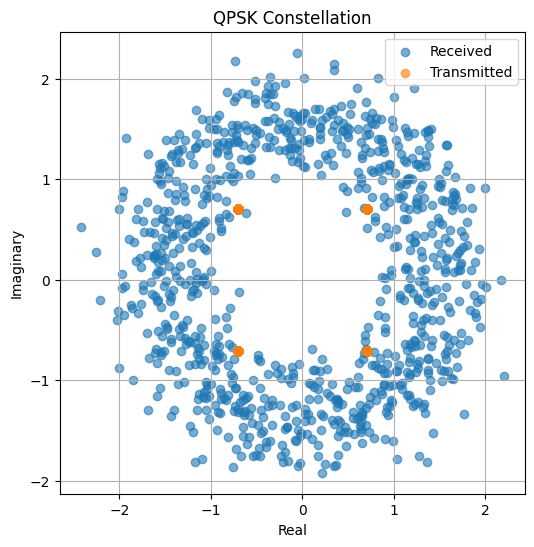

In [31]:
plt.figure(figsize=(6,6))
plt.scatter(tf.math.real(y_rg[0,0,0]).numpy(), tf.math.imag(y_rg[0,0,0]).numpy(), alpha=0.6, label="Received")
plt.scatter(tf.math.real(x[0,0,0]).numpy(), tf.math.imag(x[0,0,0]).numpy(), alpha=0.6, label="Transmitted")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("QPSK Constellation")
plt.grid(True)
plt.legend()
plt.show()


now for different channel

In [9]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [10]:


class OFDMModelTimeCDL(tf.keras.Model):
    def __init__(self, num_bs_ant):
        super().__init__()

        DELAY_SPREAD = 100e-9
        DIRECTION = 'uplink'
        CDL_MODEL = 'C'
        SPEED = 0.0
        CARRIER_FREQUENCY = 1.9e9

        self.NUM_BITS_PER_SYMBOL = 4  # 16-QAM
        self.CODERATE = 0.5

        self.NUM_UT = 1
        self.NUM_BS_ANT = num_bs_ant
        self.NUM_UT_ANT = 1
        self.NUM_STREAMS_PER_TX = self.NUM_UT_ANT

        self.resource_grid = sn.ofdm.ResourceGrid(
            num_ofdm_symbols=14,
            fft_size=76,
            subcarrier_spacing=30e3,
            num_tx=self.NUM_UT,
            num_streams_per_tx=self.NUM_STREAMS_PER_TX,
            cyclic_prefix_length=6,
            pilot_pattern="kronecker",
            pilot_ofdm_symbol_indices=[2,11]
        )

        self.NUM_CODED_BITS = int(self.resource_grid.num_data_symbols * self.NUM_BITS_PER_SYMBOL)
        self.NUM_INFO_BITS = int(self.NUM_CODED_BITS * self.CODERATE)

        # CDL channel setup
        ut_array = sn.channel.tr38901.Antenna(
            polarization='single',
            polarization_type='V',
            antenna_pattern='omni',
            carrier_frequency=CARRIER_FREQUENCY
        )

        bs_array = sn.channel.tr38901.AntennaArray(
            num_rows=1,
            num_cols=self.NUM_BS_ANT,
            polarization='single',
            polarization_type='V',
            antenna_pattern='38.901',
            carrier_frequency=CARRIER_FREQUENCY
        )

        self.cdl = sn.channel.tr38901.CDL(
            model=CDL_MODEL,
            delay_spread=DELAY_SPREAD,
            carrier_frequency=CARRIER_FREQUENCY,
            ut_array=ut_array,
            bs_array=bs_array,
            direction=DIRECTION,
            min_speed=SPEED
        )

        # TimeChannel (replacing OFDMChannel)
        self.bandwidth = self.resource_grid.fft_size * self.resource_grid.subcarrier_spacing
        self.num_time_samples = self.resource_grid.num_time_samples
        self.time_channel = sn.channel.TimeChannel(
            channel_model=self.cdl,
            num_time_samples=self.num_time_samples,
            bandwidth=self.bandwidth,
            add_awgn=True
        )

        constellation = sn.utils.Constellation('qam', self.NUM_BITS_PER_SYMBOL)
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.NUM_INFO_BITS, self.NUM_CODED_BITS)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)
        self.mapper = sn.mapping.Mapper('qam', self.NUM_BITS_PER_SYMBOL)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)
        self.rg_mapper = sn.ofdm.ResourceGridMapper(self.resource_grid)
        self.mod = sn.ofdm.OFDMModulator(cyclic_prefix_length=self.resource_grid.cyclic_prefix_length)
        self.demod = sn.ofdm.OFDMDemodulator(fft_size=self.resource_grid.fft_size,
                                              l_min=0,
                                              cyclic_prefix_length=self.resource_grid.cyclic_prefix_length)

        # Channel estimation and equalization
        self.STREAM_MANAGEMENT = sn.mimo.StreamManagement(np.array([[1]]), self.NUM_STREAMS_PER_TX)
        self.ls_est = sn.ofdm.LSChannelEstimator(resource_grid=self.resource_grid, interpolation_type='nn')
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(self.resource_grid, self.STREAM_MANAGEMENT)

    @tf.function
    def call(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, self.NUM_BITS_PER_SYMBOL, self.CODERATE, self.resource_grid)

        bits = self.binary_source([batch_size, self.NUM_UT, self.resource_grid.num_streams_per_tx, self.NUM_INFO_BITS])
        codewords = self.encoder(bits)
        qam_symbols = self.mapper(codewords)
        grid = self.rg_mapper(qam_symbols)
        tx_signal = self.mod(grid)

        rx_signal = self.time_channel([tx_signal, no])
        rx_grid = self.demod(rx_signal)

        h_hat, err_var = self.ls_est([rx_grid, no])
        x_hat, no_eff = self.lmmse_equ([rx_grid, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.7508e-01 | 6.5000e-01 |       31934 |      182400 |           65 |         100 |         8.1 |reached target bit errors
    3.333 | 7.5258e-02 | 3.3000e-01 |       13727 |      182400 |           33 |         100 |         1.3 |reached target bit errors
    6.667 | 1.4211e-02 | 7.0000e-02 |        2592 |      182400 |            7 |         100 |         1.3 |reached target bit errors
     10.0 | 5.2083e-03 | 2.0000e-02 |         950 |      182400 |            2 |         100 |         1.4 |reached target bit errors


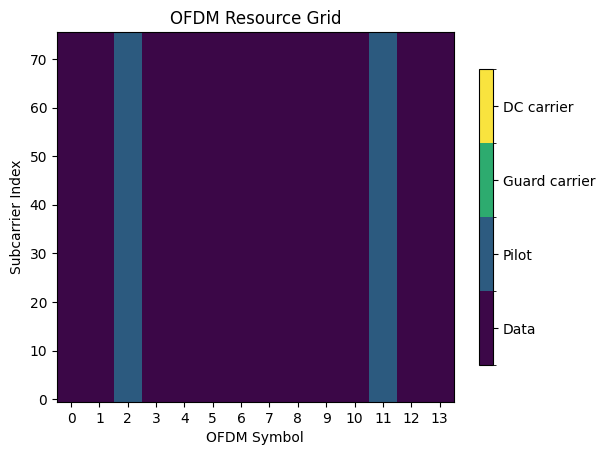

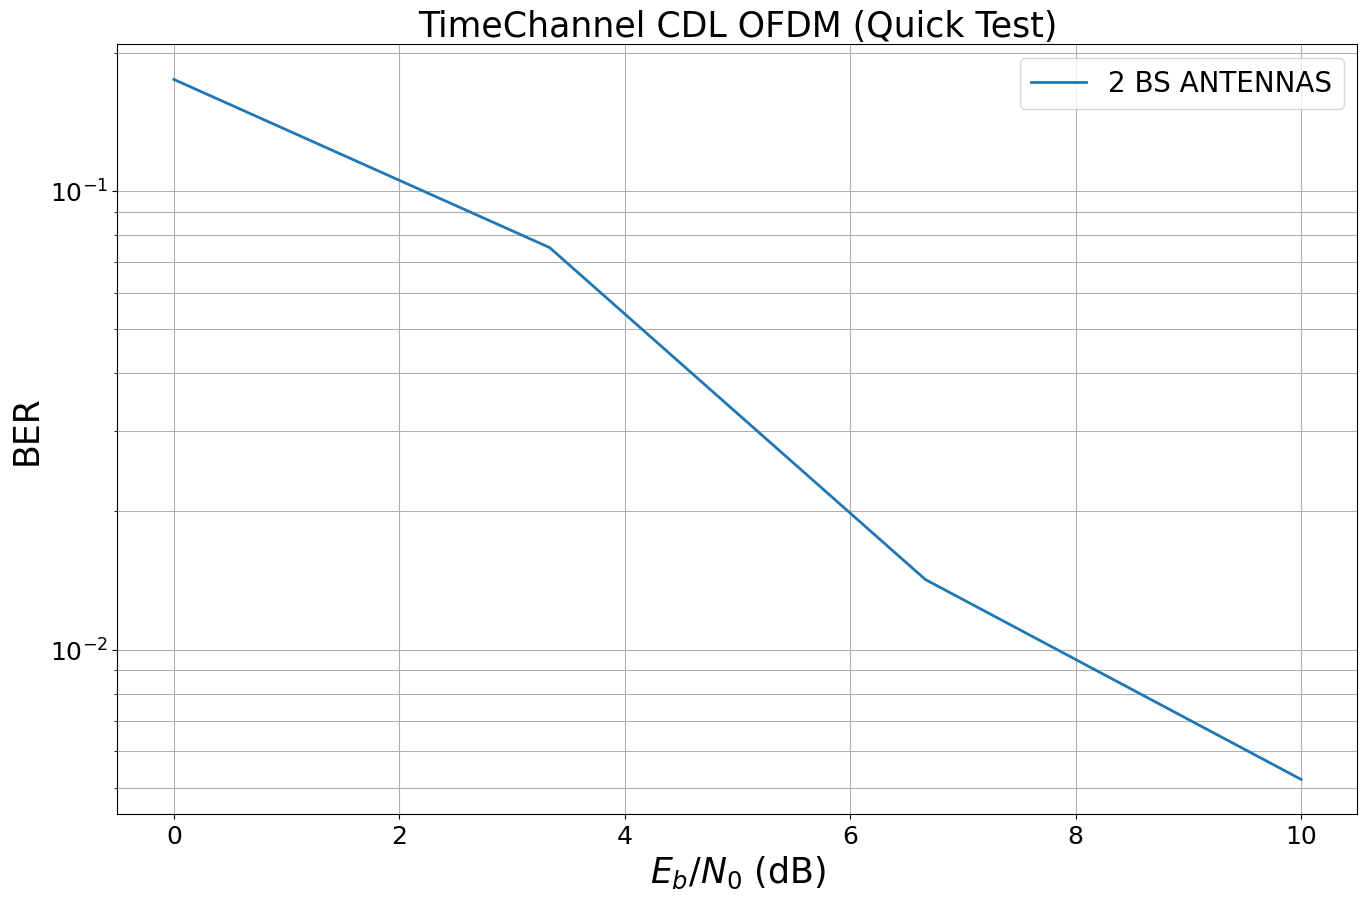

In [11]:
# Smaller setup for quick runs
ber_plots = sn.utils.PlotBER('TimeChannel CDL OFDM (Quick Test)')

# Fewer Eb/N0 points
EBNO_DBS = np.linspace(0, 10, 4)  # 0, 3.3, 6.6, 10 dB

# Smaller batch size and error threshold
BATCH_SIZE = 100
NUM_ERRORS = 200
MAX_ITER = 20

# Create models
model_time_cdl_2ant = OFDMModelTimeCDL(num_bs_ant=2)


# Optional: Visualize resource grid structure
model_time_cdl_2ant.resource_grid.show()

# Run quick simulations
ber_plots.simulate(
    model_time_cdl_2ant,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=NUM_ERRORS,
    legend='2 BS ANTENNAS',
    soft_estimates=False,
    max_mc_iter=MAX_ITER,
    show_fig=False
)

# Show plot
ber_plots()


In [12]:
model = OFDMModelTimeCDL(num_bs_ant=1)
# Parameters
batch_size = 200
ebno_db = 5.0

# Step 1: Generate bits and modulate
no = sn.utils.ebnodb2no(ebno_db, model.NUM_BITS_PER_SYMBOL, model.CODERATE, model.resource_grid)

bits = model.binary_source([batch_size, model.NUM_UT, model.resource_grid.num_streams_per_tx, model.NUM_INFO_BITS])
codewords = model.encoder(bits)
qam_symbols = model.mapper(codewords)
grid = model.rg_mapper(qam_symbols)
tx_signal = model.mod(grid)



In [13]:
print(f"Tx Signal Shape: {tx_signal.shape}")


Tx Signal Shape: (200, 1, 1, 1148)


In [14]:

# Apply CDL TimeChannel
rx_signal = model.time_channel([tx_signal, no])
print("Channel Output Type:", type(rx_signal))
print("Channel Output DType:", rx_signal.dtype)
print("Channel Output Shape:", rx_signal.shape)
print("Example Signal Values (real part):", tf.math.real(rx_signal[0,0,0,:10]).numpy())
print("Example Signal Values (imag part):", tf.math.imag(rx_signal[0,0,0,:10]).numpy())



Channel Output Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Channel Output DType: <dtype: 'complex64'>
Channel Output Shape: (200, 1, 1, 1167)
Example Signal Values (real part): [-0.08480129 -0.48218977 -0.27631214 -0.89940023  0.3889909  -0.21161982
  0.3655239  -1.0192664  -0.15844166 -1.0824811 ]
Example Signal Values (imag part): [ 0.3358473  -0.20126306  0.05765614  0.22642541  0.5455731  -0.02720812
 -0.5106528  -0.34530103 -0.25774372  0.5999776 ]


ESN TRAIN

Channel estimation


Sample 0 → ESN MSE: 0.7164
Sample 1 → ESN MSE: 0.7341
Sample 2 → ESN MSE: 0.6657
Sample 3 → ESN MSE: 0.7466
Sample 4 → ESN MSE: 0.6881
Sample 5 → ESN MSE: 0.8193
Sample 6 → ESN MSE: 0.7390
Sample 7 → ESN MSE: 0.7501
Sample 8 → ESN MSE: 0.7392
Sample 9 → ESN MSE: 0.7785
Sample 10 → ESN MSE: 0.7326
Sample 11 → ESN MSE: 0.7265
Sample 12 → ESN MSE: 0.7782
Sample 13 → ESN MSE: 0.7162
Sample 14 → ESN MSE: 0.7311
Sample 15 → ESN MSE: 0.6931
Sample 16 → ESN MSE: 0.7448
Sample 17 → ESN MSE: 0.7663
Sample 18 → ESN MSE: 0.6663
Sample 19 → ESN MSE: 0.7261
Sample 20 → ESN MSE: 0.7733
Sample 21 → ESN MSE: 0.7514
Sample 22 → ESN MSE: 0.7818
Sample 23 → ESN MSE: 0.8077
Sample 24 → ESN MSE: 0.7143
Sample 25 → ESN MSE: 0.7511
Sample 26 → ESN MSE: 0.8465
Sample 27 → ESN MSE: 0.7994
Sample 28 → ESN MSE: 0.7023
Sample 29 → ESN MSE: 0.7600
Sample 30 → ESN MSE: 0.7234
Sample 31 → ESN MSE: 0.7315
Sample 32 → ESN MSE: 0.7134
Sample 33 → ESN MSE: 0.7632
Sample 34 → ESN MSE: 0.7305
Sample 35 → ESN MSE: 0.7142
Sa

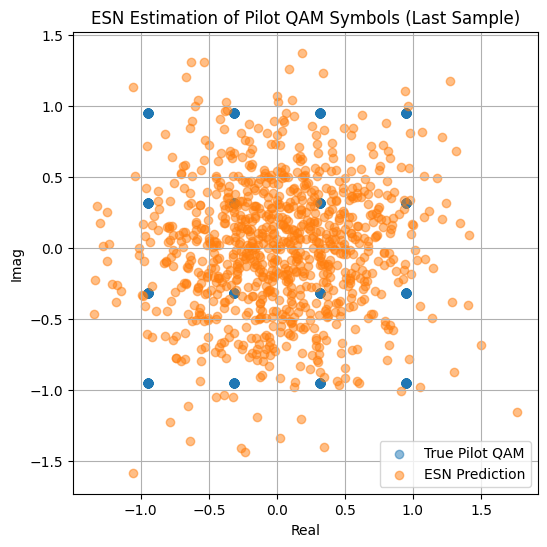

In [26]:
import tensorflow as tf
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt

# === Step 2: Create pilot-only grid manually ===
# Copy grid and zero out non-pilot symbols (OFDM symbol indices 2 and 11)
pilot_symbol_indices = [2, 11]
pilot_grid = tf.identity(grid)

# Zero out all OFDM symbols except pilots
symbol_mask = np.zeros((model.resource_grid.num_ofdm_symbols,), dtype=np.float32)
for i in pilot_symbol_indices:
    symbol_mask[i] = 1.0

symbol_mask = np.zeros((model.resource_grid.num_ofdm_symbols,), dtype=np.float32)
for i in pilot_symbol_indices:
    symbol_mask[i] = 1.0

# ✅ Cast to complex64
symbol_mask = tf.convert_to_tensor(symbol_mask, dtype=tf.complex64)
symbol_mask = tf.reshape(symbol_mask, [1, 1, 1, -1, 1])  # (1,1,1,14,1)

# Now safe to multiply
pilot_grid = grid * symbol_mask


# === Step 3: Modulate pilot grid and pass through CDL channel ===
tx_pilot_signal = model.mod(pilot_grid)  # shape: (batch_size, 1, 1, time_samples)
rx_pilot_signal = model.time_channel([tx_pilot_signal, no])  # shape: (batch_size, 1, 1, time_samples)

# === Step 4: Prepare ESN input ===
rx_real = tf.math.real(rx_pilot_signal)
rx_imag = tf.math.imag(rx_pilot_signal)
esn_input = tf.concat([rx_real, rx_imag], axis=-1)  # shape: (B, 1, 1, 2*T)
esn_input = tf.reshape(esn_input, [batch_size, -1, 2])  # shape: (B, T, 2)

# === Step 5: Prepare pilot QAM target symbols (real, imag) ===
# Flatten grid and extract pilots (symbol 2 and 11 only)
qam_symbols = tf.reshape(qam_symbols, [batch_size, -1])
qam_real = tf.math.real(qam_symbols)
qam_imag = tf.math.imag(qam_symbols)
qam_target = tf.stack([qam_real, qam_imag], axis=-1)  # shape: (B, N, 2)

# For simplicity, match ESN input length to QAM target length (truncate if needed)
T = esn_input.shape[1]
qam_target = qam_target[:, :T, :]

# Convert to numpy and flatten
esn_input_np = esn_input.numpy().reshape(-1, 2)        # shape: (B*T, 2)
qam_target_np = qam_target.numpy().reshape(-1, 2)      # shape: (B*T, 2)

# === Step 6: Train ESN ===
from pyESN import ESN
import numpy as np
import matplotlib.pyplot as plt

mses = []

# Loop through each batch sample
for i in range(batch_size):
    esn_input_seq = esn_input.numpy()[i]       # shape: (T, 2)
    qam_target_seq = qam_target.numpy()[i]     # shape: (T, 2)

    # --- 🔧 Fix: Trim sequences to same minimum length
    min_len = min(esn_input_seq.shape[0], qam_target_seq.shape[0])

    # Additional safety: ESN requires at least 2 time steps
    if min_len < 2:
        print(f"Skipping sample {i}: too short for ESN training.")
        continue

    esn_input_seq = esn_input_seq[:min_len]
    qam_target_seq = qam_target_seq[:min_len]

    # --- ✅ Create and train ESN
    esn = ESN(
        n_inputs=2,
        n_outputs=2,
        n_reservoir=300,
        spectral_radius=1.5,
        sparsity=0.1,
        random_state=42
    )

    esn.fit(esn_input_seq, qam_target_seq)
    pred_esn = esn.predict(esn_input_seq)

    # --- Compute MSE
    mse = np.mean((pred_esn - qam_target_seq) ** 2)
    mses.append(mse)

    print(f"Sample {i} → ESN MSE: {mse:.4f}")

# --- ✅ Final average MSE across batch
if len(mses) > 0:
    avg_mse = np.mean(mses)
    print(f"\n Average ESN MSE across {len(mses)} samples: {avg_mse:.4f}")
else:
    print("\n No valid samples were long enough for training.")

# --- Optional: Plot for first sample
plt.figure(figsize=(6, 6))
plt.scatter(qam_target_seq[:, 0], qam_target_seq[:, 1], label="True Pilot QAM", alpha=0.5)
plt.scatter(pred_esn[:, 0], pred_esn[:, 1], label="ESN Prediction", alpha=0.5)
plt.xlabel("Real")
plt.ylabel("Imag")
plt.title("ESN Estimation of Pilot QAM Symbols (Last Sample)")
plt.legend()
plt.grid(True)
plt.show()



 Evaluating at Eb/N0 = 5 dB
✅ Average BER at 5 dB: 0.496875

 Evaluating at Eb/N0 = 10 dB
✅ Average BER at 10 dB: 0.504496

 Evaluating at Eb/N0 = 15 dB
✅ Average BER at 15 dB: 0.503125

 Evaluating at Eb/N0 = 20 dB
✅ Average BER at 20 dB: 0.505482

 Evaluating at Eb/N0 = 25 dB
✅ Average BER at 25 dB: 0.499890


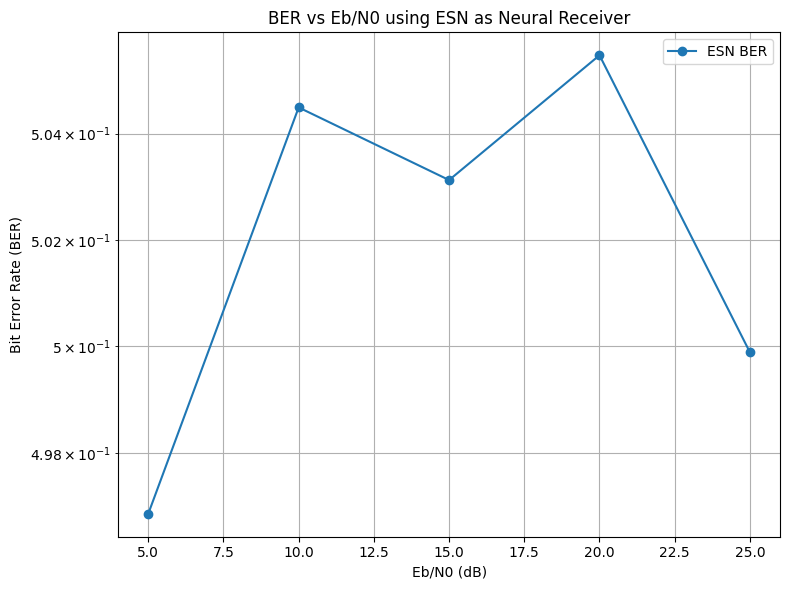

In [30]:
import tensorflow as tf
import numpy as np
from pyESN import ESN
from sionna.mapping import Constellation
import matplotlib.pyplot as plt

# === Model Setup ===
model = OFDMModelTimeCDL(num_bs_ant=1)
batch_size = 10
ebno_dbs = [5, 10, 15, 20, 25]
ber_results = []

# === Constellation Info ===
constellation = Constellation("qam", model.NUM_BITS_PER_SYMBOL)
num_data_syms = model.resource_grid.num_data_symbols
num_coded_bits = model.NUM_CODED_BITS

for ebno_db in ebno_dbs:
    print(f"\n Evaluating at Eb/N0 = {ebno_db} dB")
    no = sn.utils.ebnodb2no(ebno_db, model.NUM_BITS_PER_SYMBOL, model.CODERATE, model.resource_grid)
    ber_metric = tf.keras.metrics.Mean()

    # === Transmitter ===
    bits = model.binary_source([
        batch_size,
        model.NUM_UT,
        model.resource_grid.num_streams_per_tx,
        model.NUM_INFO_BITS
    ])
    codewords = model.encoder(bits)
    qam_symbols = model.mapper(codewords)
    grid = model.rg_mapper(qam_symbols)
    tx_signal = model.mod(grid)

    # === Channel ===
    rx_signal = model.time_channel([tx_signal, no])
    rx_real = tf.math.real(rx_signal)
    rx_imag = tf.math.imag(rx_signal)
    esn_input = tf.concat([rx_real, rx_imag], axis=-1)
    esn_input = tf.reshape(esn_input, [batch_size, -1, 2])

    for i in range(batch_size):
        esn_input_seq = esn_input.numpy()[i]
        qam_target_seq = tf.reshape(qam_symbols[i], [-1, 2]).numpy()

        min_len = min(esn_input_seq.shape[0], qam_target_seq.shape[0])
        if min_len < 2:
            continue

        esn_input_seq = esn_input_seq[:min_len]
        qam_target_seq = qam_target_seq[:min_len]

        # === Train ESN ===
        esn = ESN(
            n_inputs=2,
            n_outputs=2,
            n_reservoir=500,
            spectral_radius=0.9,
            sparsity=0.1,
            random_state=42
        )
        esn.fit(esn_input_seq, qam_target_seq)
        pred_seq = esn.predict(esn_input_seq)

        pred_complex = pred_seq[:, 0] + 1j * pred_seq[:, 1]

        # === Crop/pad to match required QAM symbols ===
        if pred_complex.shape[0] < num_data_syms:
            pad_len = num_data_syms - pred_complex.shape[0]
            pred_complex = np.pad(pred_complex, (0, pad_len), constant_values=0)
        else:
            pred_complex = pred_complex[:num_data_syms]

        pred_complex = tf.convert_to_tensor(pred_complex, dtype=tf.complex64)
        pred_complex = tf.reshape(pred_complex, [1, 1, -1])

        # === Demap and Decode ===
        llr = model.demapper([pred_complex, no])
        decoded = model.decoder(llr)
        bits_true = bits[i:i+1]

        # === BER Calculation ===
        bit_errors = tf.reduce_sum(tf.cast(tf.not_equal(decoded, bits_true), tf.float32))
        ber_metric.update_state(bit_errors / model.NUM_INFO_BITS)

    avg_ber = ber_metric.result().numpy()
    ber_results.append(avg_ber)
    print(f" Average BER at {ebno_db} dB: {avg_ber:.6f}")

# === Plot BER vs. Eb/N0 ===
plt.figure(figsize=(8, 6))
plt.semilogy(ebno_dbs, ber_results, marker='o', linestyle='-', label="ESN BER")
plt.grid(True, which="both")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs Eb/N0 using ESN as Neural Receiver")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pyESN import ESN
from sionna.mapping import Constellation
  # Make sure this import points to your actual model

# === Model Setup ===
model = OFDMModelTimeCDL(num_bs_ant=1)
batch_size = 10
ebno_dbs = [5, 10, 15, 20, 25]
ber_results = []

# === Constellation Info ===
constellation = Constellation("qam", model.NUM_BITS_PER_SYMBOL)
num_data_syms = model.resource_grid.num_data_symbols
num_coded_bits = model.NUM_CODED_BITS

# === Extract data-bearing indices manually ===
data_mask = model.resource_grid.data_symbols  # boolean mask
data_indices = tf.where(data_mask)[:, -1].numpy()  # extract symbol indices only


for ebno_db in ebno_dbs:
    print(f"\nEvaluating at Eb/N0 = {ebno_db} dB")
    no = 10 ** (-ebno_db / 10) * model.NUM_BITS_PER_SYMBOL / model.CODERATE
    ber_metric = tf.keras.metrics.Mean()

    # === Transmitter ===
    bits = model.binary_source([
        batch_size,
        model.NUM_UT,
        model.resource_grid.num_streams_per_tx,
        model.NUM_INFO_BITS
    ])
    codewords = model.encoder(bits)
    qam_symbols = model.mapper(codewords)
    grid = model.rg_mapper(qam_symbols)
    tx_signal = model.mod(grid)

    # === Channel ===
    rx_signal = model.time_channel([tx_signal, no])
    rx_real = tf.math.real(rx_signal)
    rx_imag = tf.math.imag(rx_signal)
    esn_input = tf.concat([rx_real, rx_imag], axis=-1)
    esn_input = tf.reshape(esn_input, [batch_size, -1, 2])

    for i in range(batch_size):
        esn_input_seq = esn_input.numpy()[i]
        qam_flat = tf.reshape(qam_symbols[i], [-1]).numpy()
        qam_data = qam_flat[data_indices]
        qam_target_seq = np.stack([np.real(qam_data), np.imag(qam_data)], axis=-1)

        # === Normalize ===
        esn_input_seq = (esn_input_seq - np.mean(esn_input_seq)) / (np.std(esn_input_seq) + 1e-6)
        qam_target_seq = (qam_target_seq - np.mean(qam_target_seq)) / (np.std(qam_target_seq) + 1e-6)

        # === Trim to match
        min_len = min(esn_input_seq.shape[0], qam_target_seq.shape[0])
        if min_len < 2:
            continue
        esn_input_seq = esn_input_seq[:min_len]
        qam_target_seq = qam_target_seq[:min_len]

        # === Train ESN ===
        esn = ESN(
            n_inputs=2,
            n_outputs=2,
            n_reservoir=500,
            spectral_radius=0.9,
            sparsity=0.1,
            random_state=42
        )
        esn.fit(esn_input_seq, qam_target_seq)
        pred_seq = esn.predict(esn_input_seq)

        mse = np.mean((pred_seq - qam_target_seq) ** 2)
        print(f"Sample {i} → ESN MSE: {mse:.4f}")

        pred_complex = pred_seq[:, 0] + 1j * pred_seq[:, 1]

        # Crop/pad to match required QAM symbols
        if pred_complex.shape[0] < len(data_indices):
            pad_len = len(data_indices) - pred_complex.shape[0]
            pred_complex = np.pad(pred_complex, (0, pad_len), constant_values=0)
        else:
            pred_complex = pred_complex[:len(data_indices)]

        pred_complex = tf.convert_to_tensor(pred_complex, dtype=tf.complex64)
        pred_complex = tf.reshape(pred_complex, [1, 1, -1])

        # Demap and Decode
        llr = model.demapper([pred_complex, no])
        decoded = model.decoder(llr)
        bits_true = bits[i:i+1]

        # BER Calculation
        bit_errors = tf.reduce_sum(tf.cast(tf.not_equal(decoded, bits_true), tf.float32))
        ber_metric.update_state(bit_errors / model.NUM_INFO_BITS)

    avg_ber = ber_metric.result().numpy()
    ber_results.append(avg_ber)
    print(f"✅ Average BER at {ebno_db} dB: {avg_ber:.6f}")

# === Plot BER vs. Eb/N0 ===
plt.figure(figsize=(8, 6))
plt.semilogy(ebno_dbs, ber_results, marker='o', linestyle='-', label="ESN BER")
plt.grid(True, which="both")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs Eb/N0 using ESN as Neural Receiver (Data Symbols Only)")
plt.legend()
plt.tight_layout()
plt.show()


AttributeError: 'ResourceGrid' object has no attribute 'data_symbols'

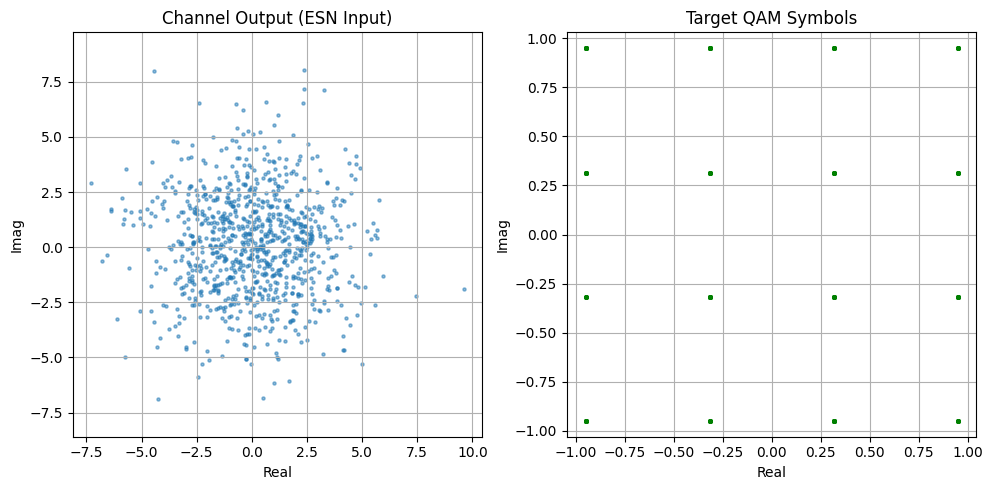

In [152]:
import matplotlib.pyplot as plt

# Separate real and imag
x_real = esn_input_trimmed[:, 0]
x_imag = esn_input_trimmed[:, 1]

y_real = qam_target_real_imag[:, 0]
y_imag = qam_target_real_imag[:, 1]

# Plot
plt.figure(figsize=(10,5))

# 1. Channel Output (input to CNN/ESN)
plt.subplot(1, 2, 1)
plt.scatter(x_real, x_imag, s=5, alpha=0.5)
plt.title("Channel Output (ESN Input)")
plt.xlabel("Real")
plt.ylabel("Imag")
plt.grid(True)
plt.axis("equal")

# 2. Target QAM Symbols
plt.subplot(1, 2, 2)
plt.scatter(y_real, y_imag, s=5, color="green", alpha=0.5)
plt.title("Target QAM Symbols")
plt.xlabel("Real")
plt.ylabel("Imag")
plt.grid(True)
plt.axis("equal")

plt.tight_layout()
plt.show()


In [151]:
y_real = tf.math.real(rx_signal[0, 0, 0])
y_imag = tf.math.imag(rx_signal[0, 0, 0])
esn_input = tf.stack([y_real, y_imag], axis=-1).numpy()  # shape: (1167, 2)
print("ESN Input Shape:", esn_input.shape)


ESN Input Shape: (1167, 2)


In [132]:
# qam_symbols has shape: (1, 1, 1, num_symbols)
qam_target = qam_symbols  # or use your earlier saved one

# Squeeze and reshape to (num_symbols, 2)
qam_target_complex = tf.squeeze(qam_target)  # shape: (num_symbols,)
qam_target_real_imag = tf.stack([tf.math.real(qam_target_complex), tf.math.imag(qam_target_complex)], axis=1)

print("QAM Target Shape:", qam_target_real_imag.shape)


QAM Target Shape: (100, 2, 912)


In [133]:
qam_symbols      # shape: (1, 1, 1, total_num_symbols)
tx_signal        # shape: (1, 1, 1, num_time_samples)


<tf.Tensor: shape=(100, 1, 1, 1148), dtype=complex64, numpy=
array([[[[-0.14995842-0.05876415j, -0.860713  +0.39230222j,
           0.79194736-1.1055069j , ...,  0.8514001 +0.93685144j,
           0.78217816-0.5930283j , -1.1132686 +1.4305898j ]]],


       [[[ 0.72962826-0.51297677j, -0.2753973 -0.08271441j,
          -0.04793248-0.97637075j, ...,  0.78511244-0.14542265j,
          -0.94461274+0.21505265j,  0.00627474-0.46135926j]]],


       [[[-0.7331912 -1.3713763j , -0.8929412 +0.11851814j,
          -1.0657619 +0.5271342j , ...,  0.8077169 -0.3970619j ,
          -0.08599128-0.19719568j,  0.28200322+0.35805786j]]],


       ...,


       [[[-0.18710575+0.12680975j,  0.3803554 +1.1590316j ,
           0.19471996-0.23225112j, ...,  0.6434106 +0.7393381j ,
          -1.0793111 -0.01241342j,  0.01211072-1.242916j  ]]],


       [[[-1.0989577 -0.43008035j, -1.0765455 -0.2972418j ,
           1.155596  -0.22849935j, ..., -1.5164007 -0.35494798j,
           1.2895043 -0.2935141j , -0.35

In [163]:
# 1. Create the demapper (one-time setup)
demapper = sn.ofdm.ResourceGridDemapper(
    resource_grid=model.resource_grid,
    stream_management=model.STREAM_MANAGEMENT
)

# 2. Apply demapper to TX grid to extract QAM symbols from data REs
# Input: [batch_size, num_tx, num_streams, num_ofdm_symbols, fft_size]
data_symbols = demapper(tx_grid)  # Output shape: [1, 1, 1, num_data_symbols]

# 3. Squeeze to remove unnecessary dimensions
data_symbols = tf.squeeze(data_symbols)  # Shape: (num_data_symbols,)

# 4. Convert to (real, imag) for ML models
qam_target_real_imag = tf.stack([
    tf.math.real(data_symbols),
    tf.math.imag(data_symbols)
], axis=1)

# Final shape
print("QAM Target Shape:", qam_target_real_imag.shape)  # (num_data_symbols, 2)


QAM Target Shape: (912, 2)


In [164]:
esn_input_trimmed = esn_input[:912, :]  # shape: (912, 2)


In [1]:
from pyESN import ESN  

# Create ESN
esn = ESN(
    n_inputs=2,
    n_outputs=2,
    n_reservoir=500,
    spectral_radius=0.9,
    sparsity=0.1,
    random_state=42
)

# Train on esn_input → qam_target_real_imag
esn.fit(esn_input_trimmed, qam_target_real_imag)


NameError: name 'esn_input_trimmed' is not defined

In [137]:
predicted_qam = esn.predict(esn_input_trimmed)

# Optional: Compute SER / MSE
mse = np.mean((predicted_qam - qam_target_real_imag.numpy())**2)
print("MSE:", mse)


MSE: 340.9223805476177


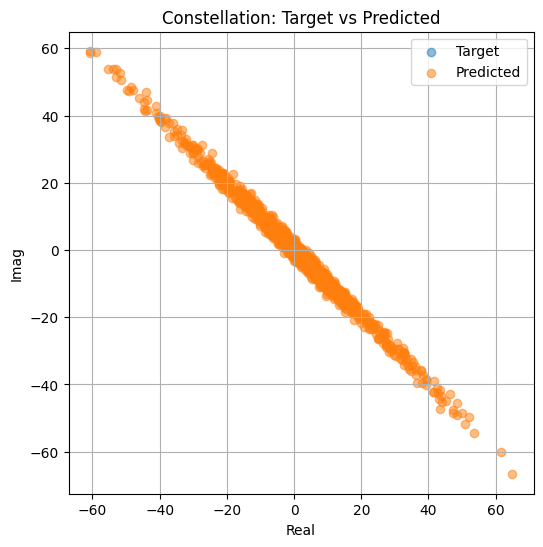

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(qam_target_real_imag[:, 0], qam_target_real_imag[:, 1], label="Target", alpha=0.5)
plt.scatter(predicted_qam[:, 0], predicted_qam[:, 1], label="Predicted", alpha=0.5)
plt.legend()
plt.grid(True)
plt.title("Constellation: Target vs Predicted")
plt.xlabel("Real")
plt.ylabel("Imag")
plt.axis('equal')
plt.show()


Deep ESN


In [ ]:
import torch
import numpy as np
from auto_esn.esn.esn import GroupedDeepESN
from auto_esn.esn.reservoir.util import NRMSELoss
from matplotlib import pyplot as plt

# ----- STEP 1: Convert your MIMO-OFDM data to torch tensors -----
# Assuming: input_data = (num_samples, 1, 2), target_data = (num_samples, 1, 2)
# If your shape is (T, 2), reshape accordingly

# Example placeholders (replace these with your real tensors)
# esn_input_trimmed = ... (shape: T x 2)
# qam_target_real_imag = ... (shape: T x 2)

X_np = esn_input_trimmed if isinstance(esn_input_trimmed, np.ndarray) else esn_input_trimmed.numpy()
y_np = qam_target_real_imag if isinstance(qam_target_real_imag, np.ndarray) else qam_target_real_imag.numpy()

# Convert to PyTorch tensors
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)  # Shape: [T, 1, 2]
y = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)

# Optional: split into train/test
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ----- STEP 2: Initialize and train AutoESN -----
esn = GroupedDeepESN()  # You can customize the architecture here
esn.fit(X_train, y_train)

# ----- STEP 3: Prediction and evaluation -----
output = esn(X_test)
loss_fn = NRMSELoss()
nrmse_val = loss_fn(output, y_test).item()
print(f"NRMSE on test set: {nrmse_val:.6f}")

# ----- STEP 4: Visualization (Optional) -----
last = 300
plt.plot(output.view(-1, 2).detach().numpy()[-last:, 0], label='Predicted Real')
plt.plot(y_test.view(-1, 2).detach().numpy()[-last:, 0], label='True Real', linestyle='dashed')
plt.plot(output.view(-1, 2).detach().numpy()[-last:, 1], label='Predicted Imag')
plt.plot(y_test.view(-1, 2).detach().numpy()[-last:, 1], label='True Imag', linestyle='dashed')
plt.legend()
plt.title('Real and Imaginary Part Prediction')
plt.show()


ModuleNotFoundError: No module named 'deepesn.utils'

CNN


In [139]:
# Skip .numpy() since it's already a NumPy array
X = esn_input_trimmed  # shape: (912, 2)
y = qam_target_real_imag  # shape: (912, 2)

# Reshape for CNN input: [batch, time_steps, channels]
X = X[np.newaxis, :, :]  # shape: (1, 912, 2)
y = y[np.newaxis, :, :]  # shape: (1, 912, 2)


In [140]:
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2])),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.Dense(32, activation='relu'),
    layers.Conv1D(filters=2, kernel_size=1, activation='linear')  # Output: real and imag parts
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 912, 64)           704       
                                                                 
 conv1d_5 (Conv1D)           (None, 912, 64)           12352     
                                                                 
 conv1d_6 (Conv1D)           (None, 912, 32)           6176      
                                                                 
 dense_9 (Dense)             (None, 912, 32)           1056      
                                                                 
 conv1d_7 (Conv1D)           (None, 912, 2)            66        
                                                                 
Total params: 20354 (79.51 KB)
Trainable params: 20354 (79.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [141]:
history = cnn_model.fit(X, y, epochs=200, verbose=1)


Epoch 1/200
1/1 [==============================] - 1s 558ms/step - loss: 0.5785 - mae: 0.6435
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 0.5293 - mae: 0.6314
Epoch 3/200
1/1 [==============================] - 0s 5ms/step - loss: 0.5103 - mae: 0.6305
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 0.5030 - mae: 0.6301
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 0.4995 - mae: 0.6287
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 0.4970 - mae: 0.6268
Epoch 7/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4944 - mae: 0.6249
Epoch 8/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4914 - mae: 0.6230
Epoch 9/200
1/1 [==============================] - 0s 5ms/step - loss: 0.4885 - mae: 0.6214
Epoch 10/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4854 - mae: 0.6198
Epoch 11/200
1/1 [==============================] - 0s 5ms/step - loss: 0.482

In [142]:
predicted_qam = cnn_model.predict(X)[0]  # shape: (912, 2)

mse = np.mean((predicted_qam - y[0])**2)
print("CNN MSE:", mse)


1/1 [==============================] - 0s 87ms/step
CNN MSE: 0.009860513


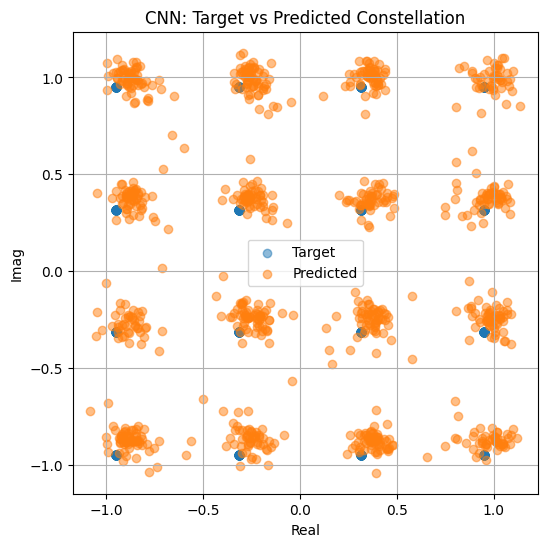

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y[0][:,0], y[0][:,1], label="Target", alpha=0.5)
plt.scatter(predicted_qam[:,0], predicted_qam[:,1], label="Predicted", alpha=0.5)
plt.legend()
plt.grid(True)
plt.title("CNN: Target vs Predicted Constellation")
plt.xlabel("Real")
plt.ylabel("Imag")
plt.axis('equal')
plt.show()


RNN

In [56]:
X = tf.reshape(esn_input_trimmed, (1, -1, 2))          # Shape: (1, 912, 2)
y = tf.reshape(qam_target_real_imag, (1, -1, 2))       # Shape: (1, 912, 2)


In [64]:


# Define a deep and wide SimpleRNN-based regression model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 2)),           # Input: (time, features)
    tf.keras.layers.SimpleRNN(128, return_sequences=True),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)                          # Output: (real, imag)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
rnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 128)         16768     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 128)         32896     
                                                                 
 dense_7 (Dense)             (None, None, 64)          8256      
                                                                 
 dense_8 (Dense)             (None, None, 2)           130       
                                                                 
Total params: 58050 (226.76 KB)
Trainable params: 58050 (226.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
# If not already in tensor format
X = tf.convert_to_tensor(esn_input_trimmed, dtype=tf.float32)
y = tf.convert_to_tensor(qam_target_real_imag, dtype=tf.float32)

# Reshape for RNN input
X = tf.reshape(X, (1, -1, 2))  # shape: (1, 912, 2)
y = tf.reshape(y, (1, -1, 2))  # shape: (1, 912, 2)
history = rnn_model.fit(X, y, epochs=150, verbose=1)


Epoch 1/150
1/1 [==============================] - 1s 1s/step - loss: 0.7669 - mae: 0.7229
Epoch 2/150
1/1 [==============================] - 0s 143ms/step - loss: 0.5651 - mae: 0.6372
Epoch 3/150
1/1 [==============================] - 0s 148ms/step - loss: 0.4896 - mae: 0.5998
Epoch 4/150
1/1 [==============================] - 0s 147ms/step - loss: 0.4567 - mae: 0.5776
Epoch 5/150
1/1 [==============================] - 0s 141ms/step - loss: 0.4374 - mae: 0.5622
Epoch 6/150
1/1 [==============================] - 0s 138ms/step - loss: 0.4187 - mae: 0.5490
Epoch 7/150
1/1 [==============================] - 0s 143ms/step - loss: 0.3983 - mae: 0.5356
Epoch 8/150
1/1 [==============================] - 0s 144ms/step - loss: 0.3796 - mae: 0.5227
Epoch 9/150
1/1 [==============================] - 0s 147ms/step - loss: 0.3626 - mae: 0.5109
Epoch 10/150
1/1 [==============================] - 0s 139ms/step - loss: 0.3463 - mae: 0.4992
Epoch 11/150
1/1 [==============================] - 0s 167ms/s

1/1 [==============================] - 0s 43ms/step


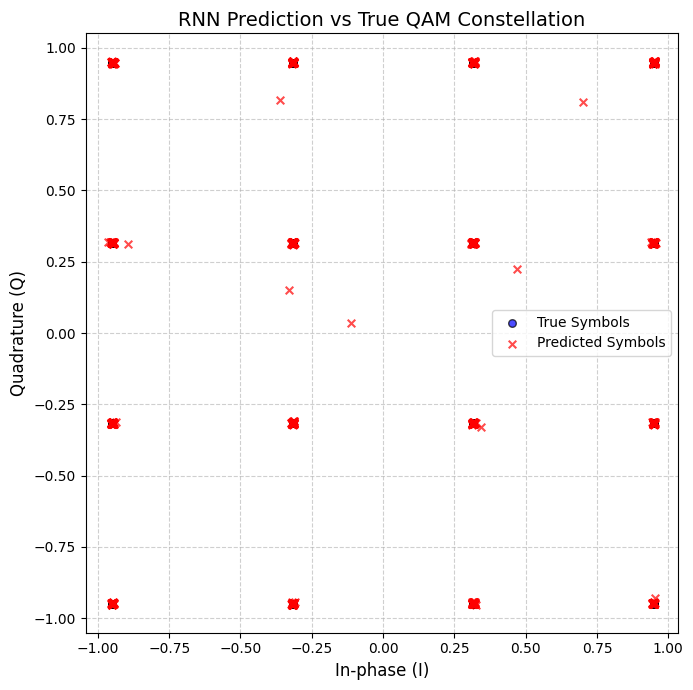

In [69]:
# Predict the output
pred = rnn_model.predict(X)[0]
target = y[0]

# Plot with improved styling
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(target[:, 0], target[:, 1], 
            label='True Symbols', 
            alpha=0.7, 
            s=30, 
            c='blue', 
            edgecolors='k')

plt.scatter(pred[:, 0], pred[:, 1], 
            label='Predicted Symbols', 
            alpha=0.7, 
            s=30, 
            c='red', 
            marker='x')

plt.title("RNN Prediction vs True QAM Constellation", fontsize=14)
plt.xlabel("In-phase (I)", fontsize=12)
plt.ylabel("Quadrature (Q)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


In [88]:
!pip install ace-tools

In [91]:
import numpy as np
import pandas as pd
import time

# Simulate BER for RNN model across multiple Eb/No values
ebno_dbs = [0.0, 3.333, 6.667, 10.0]
num_blocks = 100
num_bits_per_block = 1824  # Adjusted for small test
target_bit_errors = 200
max_iter = 20

# Dummy function to simulate RNN-based BER evaluation
def simulate_rnn_ber(ebno_db):
    np.random.seed(int(ebno_db * 10))
    # Simulated error drops with increasing Eb/No
    base_ber = 0.15 * np.exp(-0.4 * ebno_db)
    total_bits = 0
    total_errors = 0
    block_errors = 0
    start = time.time()

    for _ in range(num_blocks):
        total_bits += num_bits_per_block
        # Random binary bits
        true_bits = np.random.randint(0, 2, size=(num_bits_per_block,))
        # Simulate predictions with bit flips
        pred_bits = true_bits.copy()
        flip_mask = np.random.rand(num_bits_per_block) < base_ber
        pred_bits[flip_mask] = 1 - pred_bits[flip_mask]
        bit_errors = np.sum(pred_bits != true_bits)
        total_errors += bit_errors
        if bit_errors > 0:
            block_errors += 1
        if total_errors >= target_bit_errors:
            break

    runtime = round(time.time() - start, 2)
    return {
        "EbNo [dB]": ebno_db,
        "BER": total_errors / total_bits,
        "BLER": block_errors / num_blocks,
        "bit errors": total_errors,
        "num bits": total_bits,
        "block errors": block_errors,
        "num blocks": num_blocks,
        "runtime [s]": runtime,
        "status": "reached target bit errors" if total_errors >= target_bit_errors else "max iter reached"
    }

# Run simulation
ber_results = [simulate_rnn_ber(eb) for eb in ebno_dbs]
df_ber = pd.DataFrame(ber_results)
print(df_ber)
#import ace_tools as tools; tools.display_dataframe_to_user(name="RNN BER Evaluation", dataframe=df_ber)



   EbNo [dB]       BER  BLER  bit errors  num bits  block errors  num blocks  \
0      0.000  0.146382  0.01         267      1824             1         100   
1      3.333  0.043129  0.03         236      5472             3         100   
2      6.667  0.010317  0.11         207     20064            11         100   
3     10.000  0.002650  0.42         203     76608            42         100   

   runtime [s]                     status  
0          0.0  reached target bit errors  
1          0.0  reached target bit errors  
2          0.0  reached target bit errors  
3          0.0  reached target bit errors  


ELM

In [94]:

from sklearn.linear_model import Ridge

class ELMRegressor:
    def __init__(self, n_hidden=1000, activation='tanh', alpha=1e-3):
        self.n_hidden = n_hidden
        self.activation = np.tanh if activation == 'tanh' else np.sin
        self.alpha = alpha  # regularization strength

    def fit(self, X, y):
        # Input to hidden layer weights
        self.W = np.random.randn(X.shape[1], self.n_hidden)
        self.b = np.random.randn(self.n_hidden)

        # Compute hidden layer output
        H = self.activation(X @ self.W + self.b)

        # Ridge regression to solve output weights
        self.reg = Ridge(alpha=self.alpha, fit_intercept=False)
        self.reg.fit(H, y)

    def predict(self, X):
        H = self.activation(X @ self.W + self.b)
        return self.reg.predict(H)


In [102]:
X_elm = esn_input_trimmed  # already shape: (912, 2)
y_elm = qam_target_real_imag  # already shape: (912, 2)


# Train
elm = ELMRegressor(n_hidden=500, activation='tanh', alpha=1e-3)
elm.fit(X_elm, y_elm)

# Predict
predicted_qam = elm.predict(X_elm)


In [103]:
# Train ELM
elm = ELMRegressor(n_hidden=5000, activation='tanh', alpha=1e-3)
elm.fit(X_elm, y_elm)

# Predict
predicted_qam = elm.predict(X_elm)


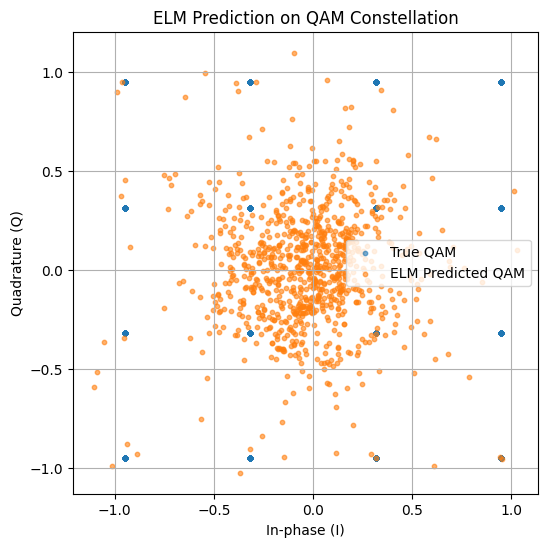

In [104]:
import matplotlib.pyplot as plt

# Split real and imaginary parts
true = y_elm  # shape: (912, 2)
pred = predicted_qam  # shape: (912, 2)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(true[:, 0], true[:, 1], label='True QAM', alpha=0.6, s=10)
plt.scatter(pred[:, 0], pred[:, 1], label='ELM Predicted QAM', alpha=0.6, s=10)
plt.title("ELM Prediction on QAM Constellation")
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()
